In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from os import walk

%matplotlib inline
import matplotlib
import datetime as dt

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.version.VERSION
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# The Power Consumption Dataset
The dataset contains 7 different features such as Global_active_power, Global_reactive_power, and Voltage. These were collected every minute beginning in 2006. This dataset was found on Kaggle.

In [6]:
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
_, _, filenames = next(walk(pardir))
filenames

['household_power_consumption.txt']

In [7]:
df = pd.read_csv(os.path.join(pardir, filenames[0]), sep=';', parse_dates={'dt':['Date','Time']}, 
                 low_memory=False, na_values=['nan','?'])

## Checking for Null Values
It looks like there are about 25,979 null values out of 2,075,259. That's approximately 1% of the data. Also, from below I can see that the null data values are all in the same row.

In [8]:
df.isnull().sum()

dt                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
df[df['Global_active_power'].isnull()].head(20)

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19725,2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41832,2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61909,2007-01-28 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98254,2007-02-22 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98255,2007-02-22 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142588,2007-03-25 17:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190497,2007-04-28 00:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, I'll need to decide what to do with the null data. One possibility is to drop the data, but then I would have gaps in the timeseries. Another possibility is to fill in the data with the average. But I don't think that's the best option since maybe the data just before the null values were at a low or at a high. Then filling it with the average would cause an upward/downward spike. I think the best option would be to backfill or forward fill the data. I think this makes the most sense since the data is in chronological order. I am going to choose ffill, which will propogate the last valid observation forward.

In [10]:
df = df.fillna(method='ffill', axis=0)
df.isnull().sum()

dt                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
df_backup = df

In [39]:
#df = df_backup.copy()
#df = df.copy()

This project will just deal with hourly predictions, so I'll start by sub-sampling the data from 1 minute intervals to 1h

In [40]:
# slice [start:stop:step], starting from index 36 take every 60th record
df = df[36::60]
date_time = df.pop('dt')

In [41]:
date_time

36        2006-12-16 18:00:00
96        2006-12-16 19:00:00
156       2006-12-16 20:00:00
216       2006-12-16 21:00:00
276       2006-12-16 22:00:00
                  ...        
2075016   2010-11-26 17:00:00
2075076   2010-11-26 18:00:00
2075136   2010-11-26 19:00:00
2075196   2010-11-26 20:00:00
2075256   2010-11-26 21:00:00
Name: dt, Length: 34588, dtype: datetime64[ns]

Here are the first few rows of data:

In [42]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
36,2.790,0.180,237.52,11.8,0.0,0.0,18.0
96,4.070,0.088,231.99,17.4,0.0,1.0,17.0
156,3.206,0.078,232.43,13.8,0.0,0.0,16.0
216,3.314,0.072,236.76,14.0,0.0,0.0,17.0
276,3.464,0.170,236.03,14.6,0.0,1.0,17.0


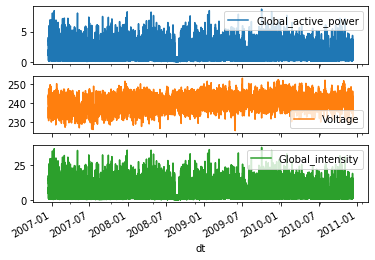

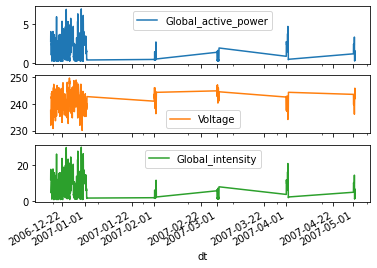

In [43]:
plot_cols = ['Global_active_power','Voltage','Global_intensity']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Inspect data

In [44]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34588.0,1.092031,1.058231,0.078,0.308,0.602,1.532,8.758
Global_reactive_power,34588.0,0.123175,0.113308,0.000,0.048,0.100,0.194,1.218
Voltage,34588.0,240.720039,3.233447,225.540,238.870,240.890,242.790,253.170
Global_intensity,34588.0,4.631178,4.451695,0.200,1.400,2.600,6.400,37.600
Sub_metering_1,34588.0,1.096999,6.078537,0.000,0.000,0.000,0.000,80.000
Sub_metering_2,34588.0,1.314155,5.883268,0.000,0.000,0.000,1.000,79.000
Sub_metering_3,34588.0,6.463687,8.444149,0.000,0.000,1.000,17.000,31.000


By inspecting the data, I can see that Sub_metering_1 and Sub_metering_2 are primarily full of 0's, although when approaching the max, they increase up to 79 and 80 respectively.

Also, I can see that the Global_active_power, Global_reactive_power, Voltage, and Global_intensity all have a relatively small standard deviation with 4.45 being the maximum standard deviation.

After inspecting the data, nothing stands out as needing to be cleaned up aside from filling the null values which was done previously. I was also checking to see if any of the columns had negative values, since that would have stood out as being out of the ordinary.

# Feature Engineering
The Date Time column is very useful, but not in this string form. I'll start by converting it to seconds

In [45]:
timestamp_s = date_time.map(dt.datetime.timestamp)

Since this is power consumption data, it may have some type of periodicity. I'm unsure of which frequencies are important. But I can figure this out by using an fft.

In [18]:
fft = tf.signal.rfft(df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))


In [19]:
n_samples_h = len(df['Global_active_power'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

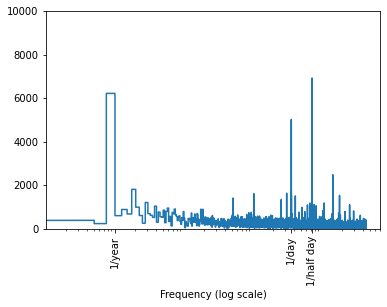

In [54]:
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524, 730.5048], labels=['1/year','1/day','1/half day'], rotation=90)
_ = plt.xlabel('Frequency (log scale)')

Here, I can see that there is periodicity every year, day, and half day with the greatest periodicity being every half day. A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" "Time of half day" and "Time of Year" signals. This gives the model access to the most important frequency features.

In [46]:
half_day = 12*60*60
day = 24*60*60
year = (365.2425)*day

df.loc[:,'Half Day sin'] = np.sin(timestamp_s * (2 * np.pi / half_day))
df.loc[:,'Half Day cos'] = np.cos(timestamp_s * (2 * np.pi / half_day))

df.loc[:,'Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df.loc[:,'Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

df.loc[:,'Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df.loc[:,'Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [47]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Half Day sin', 'Half Day cos', 'Day sin', 'Day cos',
       'Year sin', 'Year cos'],
      dtype='object')

Text(0.5, 1.0, 'Time of day signal')

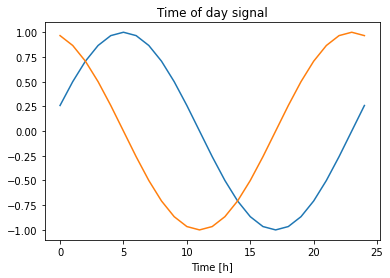

In [48]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

## Split the data
We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [49]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.
<br> <br>
The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.


In [52]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

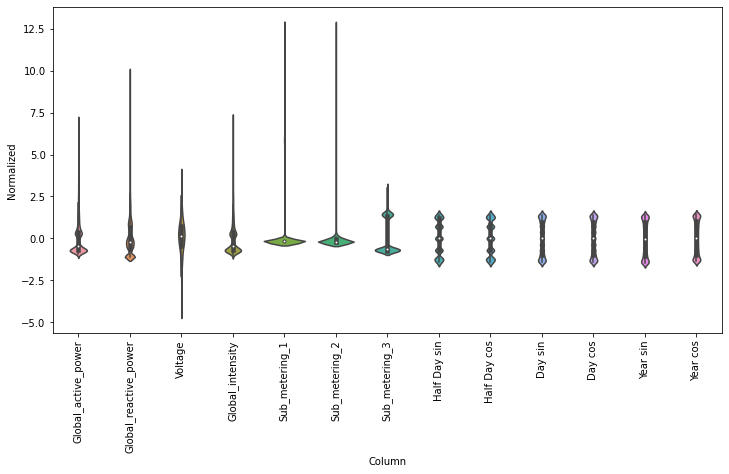

In [53]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

The code below creates a class called WindowGenerator which takes the input_width, label_width, shift, train_df, val_df, test_df, and (optional) label_columns. It then stores these as properties. It creates a dictionary with the name and index of the column_indices and the optional label_columns. Then it creates a np array with the input_indices and the label_indices. Finally, I define a `__repr__` function which returns the "official" string representation of the object (used for debugging).

In [55]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [57]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=1,
                     label_columns=['Global_active_power'])
w1.label_indices

array([24])

The below code creates a method called split_window and adds it to the WindowGenerator class. This method takes "features" which contains a list of arrays of the window size. It then splits these arrays into their inputs and labels. It then sets the shape of the inputs and labels, which will make it easier to inspect the tf.data.Datasets.

In [78]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [79]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 25, 13)
Inputs shape: (3, 24, 13)
labels shape: (3, 1, 1)


In [60]:
w1.example = example_inputs, example_labels

The below code creates a plot method and adds it to the WindowGenerator. This method creates up to 3 subplots of a user-selectd plot column. It then creates a line plot from the inputs and then a scatter plot (disconnected points) of the labels. Also, if a model exists, then it is used to make predictions and plot those predictions. Other columns besides 'Global_active_power' can be plotted, but the configuration only has labels for 'Global_active_power'.

In [68]:
def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} ',)
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

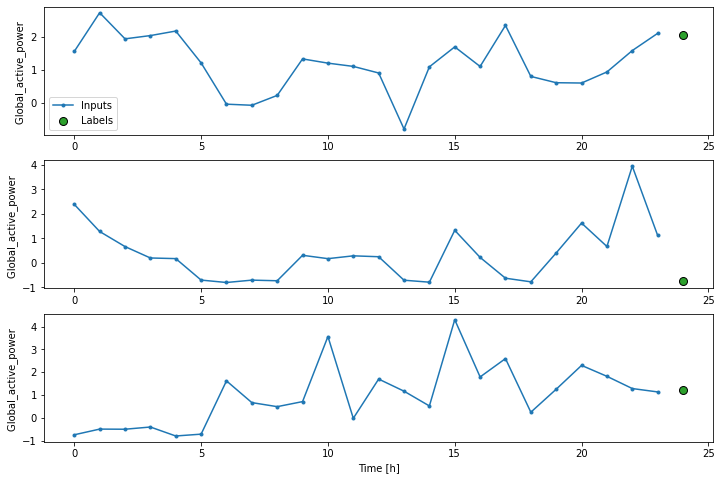

In [69]:
w1.plot()

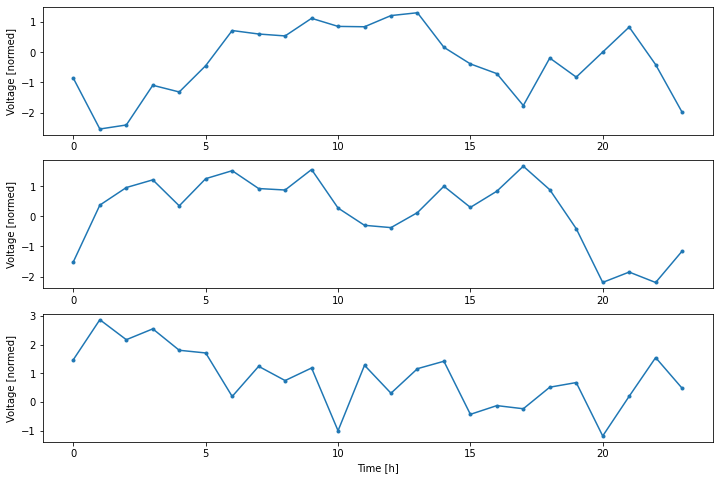

In [65]:
w1.plot(plot_col='Voltage')

The below code creates a method called make_dataset() which takes in a time series DataFrame and then converts that to a np array with type float32. This is then converted into a tensorflow timeseries_dataset_from_array which is a dataset of sliding windows.

In [70]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Here, I'm adding properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. I'm also adding a standard example batch for easy access and plotting:

In [71]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [72]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 24, 13), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [73]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 13)
Labels shape (batch, time, features): (32, 1, 1)


# Creating a single step model
This is the simplest model that can be built. It just predicts a single feature's vale 1 timestep into the future based only on the current timestep.

First, I'll configure a WindowGenerator object to produce the single-step `(input, label)` pairs:

In [82]:
single_step_window = WindowGenerator(
    input_width = 1, label_width=1, shift=1,
    label_columns = ['Global_active_power'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Global_active_power']

The window object creates tf.data.Datasets with the training, validation, and test sets. This makes it easy to iterate over batches of data.

In [83]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 13)
Labels shape (batch, time, features): (32, 1, 1)


## Setting up a baseline
The baseline will be a model that just returns the current value as the prediction, predicting "No change". It just predicts that the next timestep will be the same as this timestep.

In [129]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:, self.label_index]
        return result[:, :, tf.newaxis]

Instantiate and evaluate the model:

In [85]:
baseline = Baseline(label_index = column_indices['Global_active_power'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

217/217 [==============================] - 1s 3ms/step - loss: 0.9202 - mean_absolute_error: 0.5901


This printed some performance metrics, but they don't give very much insight into how well the model is doing. The WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample. So I will create a wider WindowGenerator that generates widows with 24h of consecutive inputs and labels at a time. 

In [86]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, 
    label_columns=['Global_active_power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Global_active_power']

In [87]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions, as expected, the lable are simply shifted right by 1h.
* The blue "Inputs" line shows the input power at each time step. The model recieves all features, this plot only shows the power.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

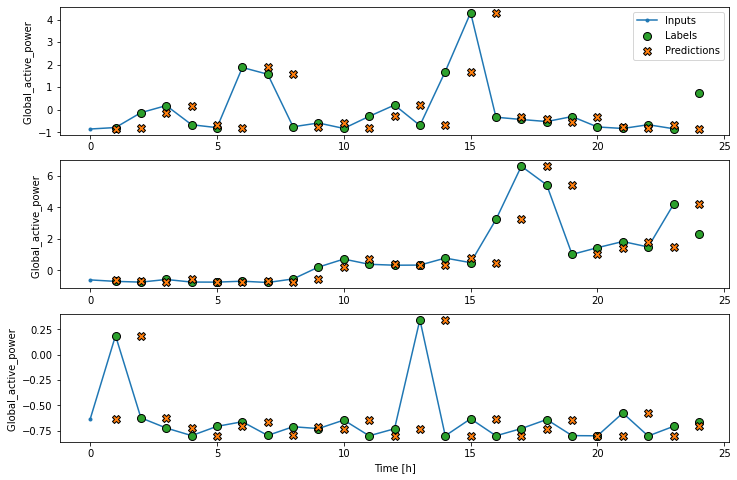

In [88]:
wide_window.plot(baseline)

## Linear Model
This will simply be a linear transformation between the input and the output. A layers.Dense with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units), it is applied independently to every item across the batch and time axes.

In [89]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [90]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


I'm going to be using many models, so I'll package the training procedure into a function:

In [91]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Training the model and evaluating the performance:

In [92]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
757/757 [==============================] - 3s 4ms/step - loss: 1.9021 - mean_absolute_error: 1.0258 - val_loss: 0.7490 - val_mean_absolute_error: 0.5850
Epoch 2/20
757/757 [==============================] - 2s 3ms/step - loss: 0.7694 - mean_absolute_error: 0.6074 - val_loss: 0.6055 - val_mean_absolute_error: 0.5258
Epoch 3/20
757/757 [==============================] - 2s 3ms/step - loss: 0.6710 - mean_absolute_error: 0.5646 - val_loss: 0.5919 - val_mean_absolute_error: 0.5215
Epoch 4/20
757/757 [==============================] - 2s 3ms/step - loss: 0.6574 - mean_absolute_error: 0.5575 - val_loss: 0.5881 - val_mean_absolute_error: 0.5206
Epoch 5/20
757/757 [==============================] - 2s 3ms/step - loss: 0.6521 - mean_absolute_error: 0.5540 - val_loss: 0.5875 - val_mean_absolute_error: 0.5206
Epoch 6/20
757/757 [==============================] - 2s 3ms/step - loss: 0.6544 - mean_absolute_error: 0.5543 - val_loss: 0.5874 - val_mean_absolute_error: 0.5206
Epoch 7/20
757/7

Like the baseline model, the linear omdel can be called on batches of wide windows:

In [93]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


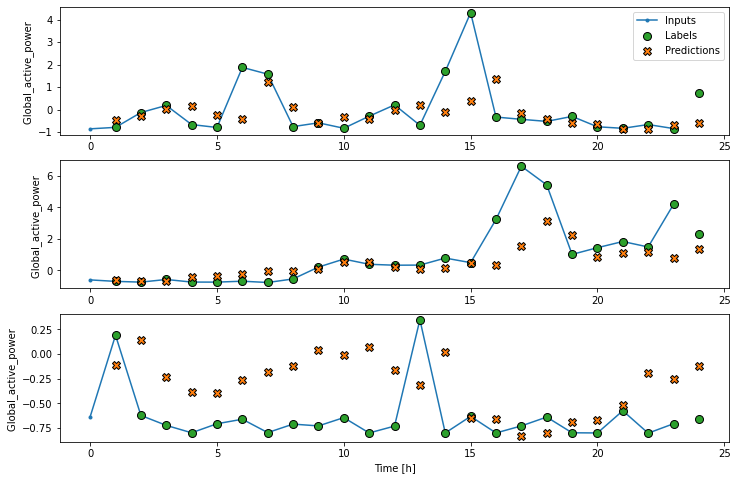

In [94]:
wide_window.plot(linear)

Linear models are relatively simple to interpret. I can pull out the layer's weights and see the weight assigned to each input. In this case, the model doesn't even place the most weight on the input 'Global_active_power'. This is one of the risks of random initialization.

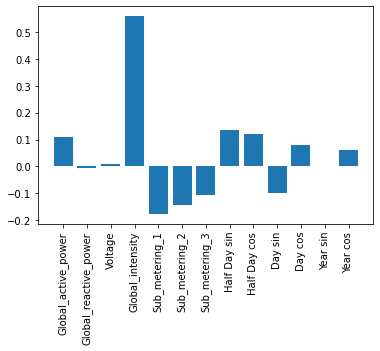

In [95]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense
Before applying models that actually operate on multiple time-steps, I'll check the performance of deeper, more powerful, single input step models. This model stacks a few Dense layers between the input and output:

In [96]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
757/757 [==============================] - 4s 5ms/step - loss: 0.7037 - mean_absolute_error: 0.5742 - val_loss: 0.5875 - val_mean_absolute_error: 0.5242
Epoch 2/20
757/757 [==============================] - 3s 5ms/step - loss: 0.6162 - mean_absolute_error: 0.5214 - val_loss: 0.5803 - val_mean_absolute_error: 0.5273
Epoch 3/20
757/757 [==============================] - 3s 5ms/step - loss: 0.6086 - mean_absolute_error: 0.5155 - val_loss: 0.5845 - val_mean_absolute_error: 0.5260
Epoch 4/20
757/757 [==============================] - 3s 5ms/step - loss: 0.6037 - mean_absolute_error: 0.5123 - val_loss: 0.5697 - val_mean_absolute_error: 0.5102
Epoch 5/20
757/757 [==============================] - 3s 5ms/step - loss: 0.5957 - mean_absolute_error: 0.5087 - val_loss: 0.5619 - val_mean_absolute_error: 0.5091
Epoch 6/20
757/757 [==============================] - 3s 5ms/step - loss: 0.5955 - mean_absolute_error: 0.5086 - val_loss: 0.5692 - val_mean_absolute_error: 0.5096
Epoch 7/20
217/2

## Multi-step dense
Next, I'll build a multi-step model using batches of 3h inputs instead of 1h inputs. 

In [99]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Global_active_power'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Global_active_power']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

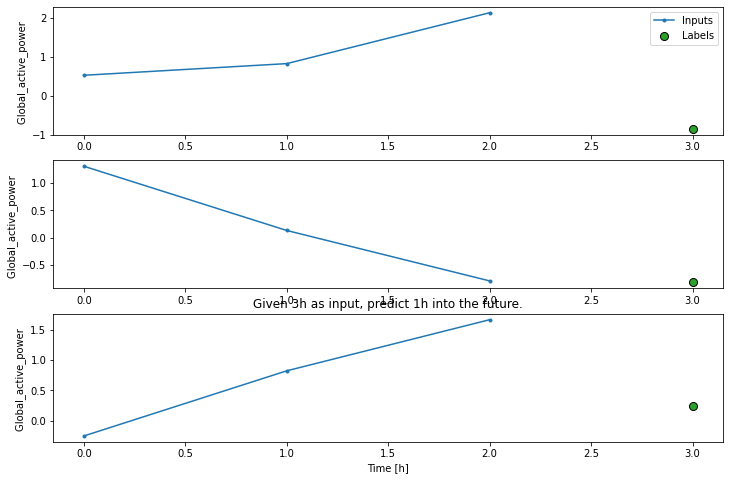

In [100]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [101]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [102]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [103]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

217/217 [==============================] - 0s 2ms/step - loss: 0.5778 - mean_absolute_error: 0.4861


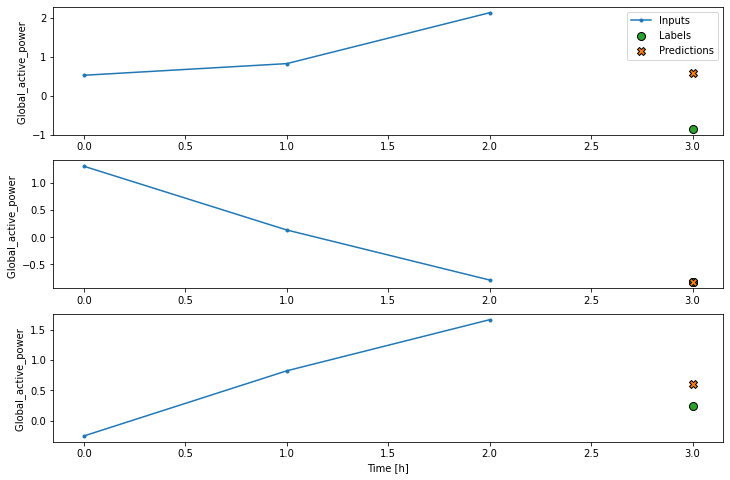

In [104]:
conv_window.plot(multi_step_dense)

One down-side of this approach is that the resulting model can only be executed on input windows of exactly the same shape. This can be fixed with a convolutional model.

In [105]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 13)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 39 but received input with shape (32, 312)


## Convolutional neural network
A few differences:
* The layers.Flatten and the first layers.Dense are replaced by a layers.Conv1D
* The layers.Reshape is no longer necessary since the convolution keeps the time axis in its output

In [106]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [107]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [108]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

217/217 [==============================] - 1s 3ms/step - loss: 0.5613 - mean_absolute_error: 0.5198


The difference between this conv_model and the multi_step_dense model is that the conv_model can be run on inputs of any length. The convolutional layer is applied to a slidign window of inputs. If it is run on a wider input, it produces a wider output

In [109]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


The output is shorter than the input. To make training or plotting work, I'll need the labels and prediction to have the same length. So I'll build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match.

In [112]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Global_active_power'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Global_active_power']

In [113]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now I can plot th emodel's predictions on a wider window. There are 3 input time steps before the first prediction since every prediction here is based on the 3 preceding timesteps.

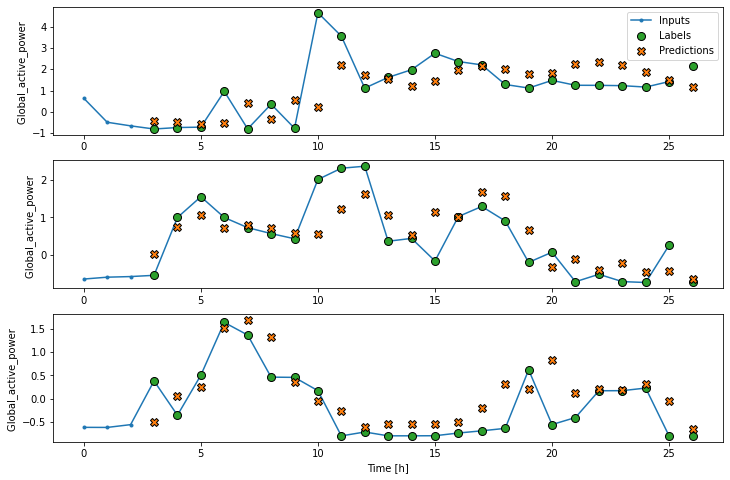

In [114]:
wide_conv_window.plot(conv_model)

## Recurrent neural network
Here, I'll implement a recurrent neural network to make predictions. Setting return_sequences to be equal to true means that the RNN returns an output for each input.

In [115]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [116]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


In [117]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

216/216 [==============================] - 1s 3ms/step - loss: 0.5523 - mean_absolute_error: 0.4932


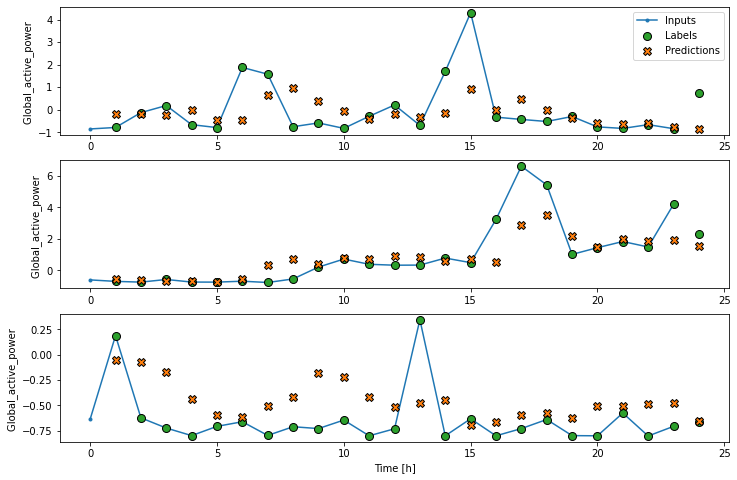

In [118]:
wide_window.plot(lstm_model)

## Performance
The below chart compares the different models that I've tried so far. The multi step dense performed the best. The second best was the LSTM.

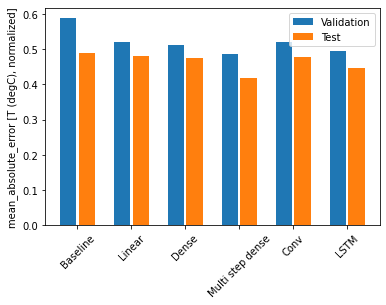

In [119]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [133]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.4886
Linear      : 0.4806
Dense       : 0.4744
Multi step dense: 0.4192
Conv        : 0.4784
LSTM        : 0.4466


# Multi-step models
The previous sections made single time step predictions, 1h into the future. Next, I'm going to look at how to expand these models to make multiple time step predictions, where the model predicts a sequcne of future values

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

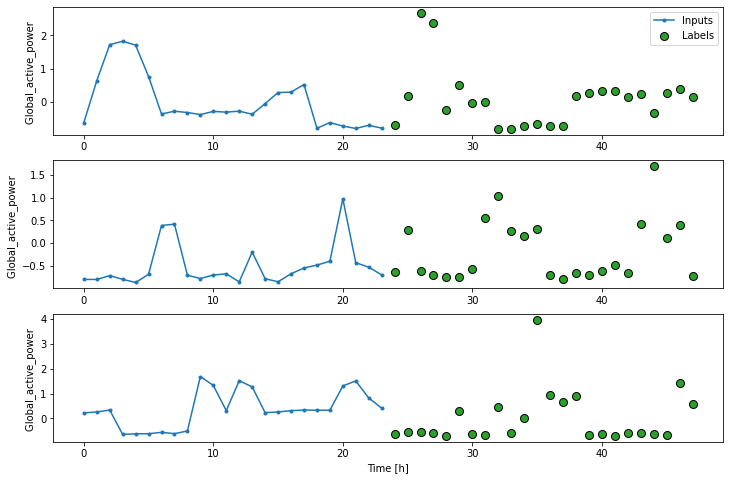

In [120]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

215/215 [==============================] - 1s 3ms/step - loss: 1.5947 - mean_absolute_error: 0.7970


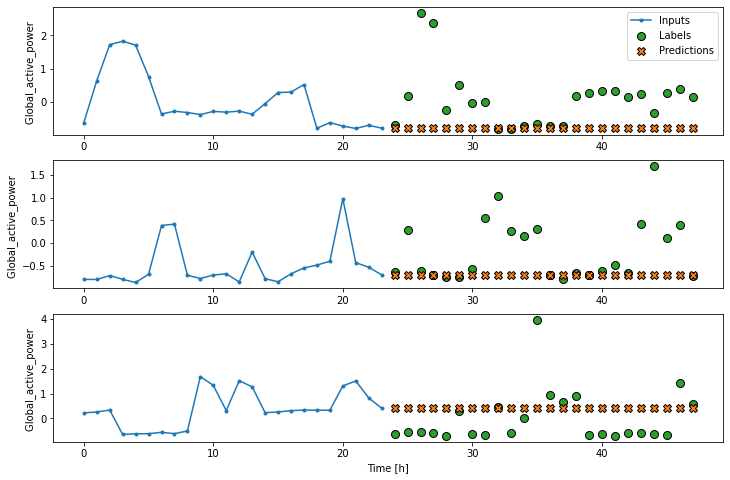

In [121]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

215/215 [==============================] - 1s 3ms/step - loss: 0.8567 - mean_absolute_error: 0.4130


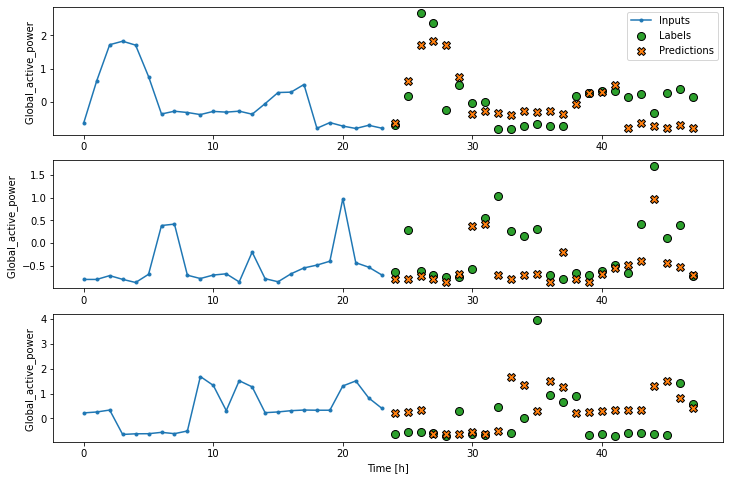

In [122]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

215/215 [==============================] - 0s 2ms/step - loss: 0.4761 - mean_absolute_error: 0.3516


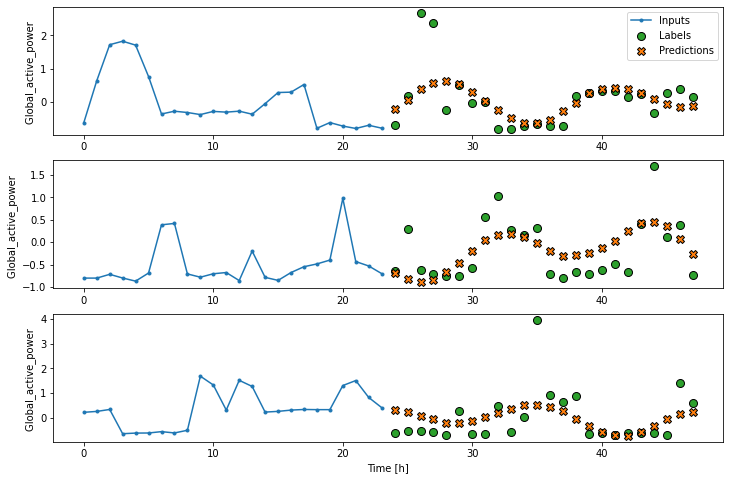

In [123]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

215/215 [==============================] - 1s 3ms/step - loss: 0.4679 - mean_absolute_error: 0.3521


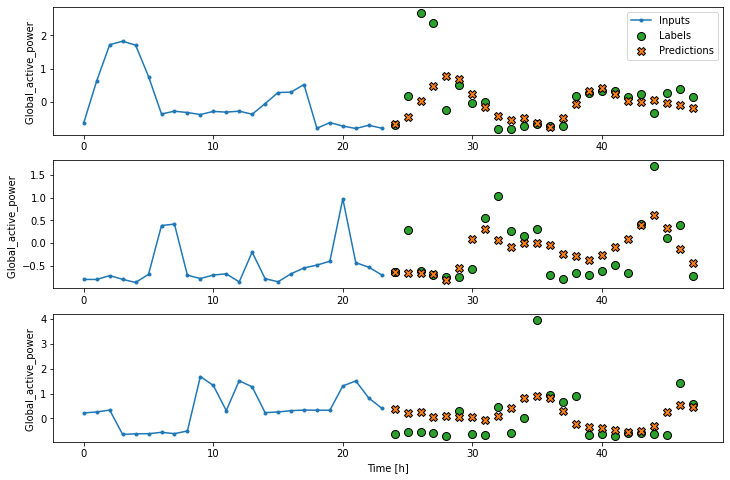

In [124]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

215/215 [==============================] - 1s 3ms/step - loss: 0.4624 - mean_absolute_error: 0.3568


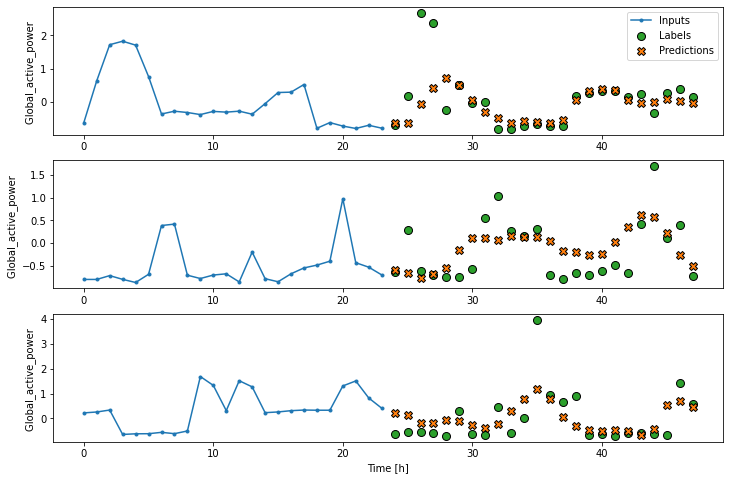

In [125]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

215/215 [==============================] - 1s 3ms/step - loss: 0.4565 - mean_absolute_error: 0.3560


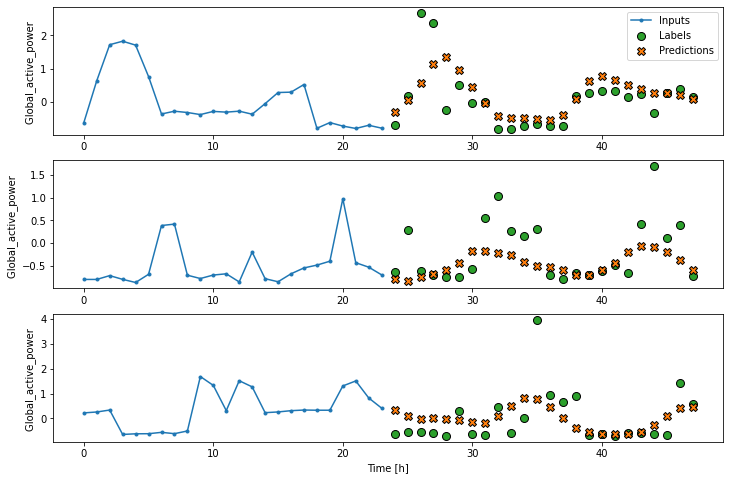

In [126]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

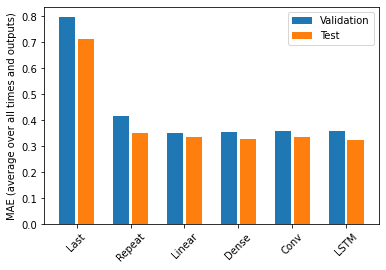

In [127]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [128]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.7130
Repeat  : 0.3501
Linear  : 0.3331
Dense   : 0.3289
Conv    : 0.3360
LSTM    : 0.3240
